# Importing Libraries 


In [1]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.5 MB 1.4 MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,manhattan_distances
import seaborn as sns
import implicit 
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
sns.set(style = 'white')

/usr/local/lib/python3.7/dist-packages/implicit/gpu/__init__.py:14: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  f"CUDA extension is built, but disabling GPU support because of '{e}'",


# Data Loading , Analysing & Preprocessing

In [3]:
df_courses=pd.read_csv('(Responses)k - compiled (1).csv')
df_courses.drop(['Please choose 6  courses that you will choose /  interest you / have chosen'], axis=1, inplace=True)

In [4]:
columns=['Gender', 'Business & Financial Technology (SIT)',
       'Information Technology (SIT)', 'Infocomm & Security (SIT)',
       'Cybersecurity  & Digital Forensics (SIT)',
       'Business Intelligence & Analytics (SIT)', 'Common ICT Programme (SIT)',
       'Experiential Product & Interior Design (SDM)',
       'Animation & Visual Effects (SDM)', 'Architecture  (SDM)',
       'Interaction Design (SDM)', 'Digital Game Art & Design (SDM)',
       'Visual Communication (SDM)', 'Motion Graphics Design (SDM)',
       'Game Development & Technology (SDM)', 'Applied Chemistry (SAS)',
       'Biologics & Process Technology (SAS)',
       'Chemical & Pharmaceutical Technology (SAS)',
       'Food Science & Nutrition (SAS)', 'Pharmaceutical Science (SAS)',
       'Accountancy & Finance (SBM)', 'Banking & Finance (SBM)',
       'Business Management (SBM)', 'Food & Beverage Business (SBM)',
       'Hospitality & Tourism Management (SBM)', 'Mass Media Management (SBM)',
       'Sport & Wellness Management (SBM)', 'Common Business Programme (SBM)',
       'Advanced & Digital Manufacturing (SEG)',
       'Aeronautical & Aerospace Technology (SEG)',
       'Aerospace Systems & Management (SEG)', 'AI & Data Engineering (SEG)',
       'Biomedical Engineering (SEG)',
       'Electronic & Computer Engineering (SEG)',
       'Engineering with Business (SEG)', 'Infocomm & Media Engineering (SEG)',
       'Nanotechnology & Materials Science (SEG)',
       'Robotics & Mechatronics (SEG)', 'Common Engineering Programme (SEG)',
       'Nursing (SHSS)', 'Oral Health Therapy (SHSS)', 'Social Work (SHSS)']
df_courses=df_courses[columns]

In [5]:
grp_dict={}
test_data={}
grp = df_courses.groupby(['Gender'])
for name, df in grp:
    df.drop(['Gender'], axis=1, inplace=True)
    df=df.reset_index().drop(['index'],axis=1)
    df_mat=np.array(df)
    test_indxs=[]
    ### extract test data ###
    for i in range(len(df)):
        indxs=np.where(np.array(df.iloc[i])==1)[0]
        test_indx=np.random.choice(indxs, size=1)[0]
        df_mat[i][test_indx]=0
        test_indxs.append(test_indx)
    ##########################
    test_data[name]=test_indxs
    grp_dict[name]=df_mat
keys=list(grp_dict.keys())
courses=np.array(df.columns)

In [6]:
keys #check to see whats the key

['Female', 'Male']

one food from each user has been selected as the test data and the index of the 

---

column that represents the selected food is saved in a list.

In [7]:
df_anly=df_courses.groupby(['Gender']).sum().reset_index()

In [8]:
df_anly['group id']=[i for i in range(len(df_anly))]

In [9]:
# for name in courses:
#     sns.barplot(x = 'group id',y = name,data = df_anly)
#     plt.show()

# Collaborative filtering

## Model 1:  (features from user-food matrix & cosine similarity)

vectors in the user-food matrix have been directly used as feature vectors 

In [10]:
sim_mat_dic_m1={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    food_similarity_matrix=cosine_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on cosine similarity
    sim_mat_dic_m1[keys[i]]=food_similarity_matrix

## Model 2: (features from Singular value decomposition& cosine similarity)

Singular value decomposition  has been used to generate feature vectors.

In [11]:
sim_mat_dic_m2={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    R = np.array(df).T
    mean = np.mean(R, axis = 1)
    data_matrix = R - mean.reshape(-1, 1)
    U, sigma, Vt = svds(data_matrix, k = np.min(data_matrix.shape)-1)
    sigma = np.diag(sigma)
    feature_matrix=np.dot(U, sigma)
    food_similarity_matrix=cosine_similarity(feature_matrix,feature_matrix) #Find the user-similarity matrix based on cosine similarity
    sim_mat_dic_m2[keys[i]]=food_similarity_matrix

## Model 3: (features from user-food matrix & euclidean distance similarity)

In [12]:
def euclidean_similarity(matrix1,matrix2):
    euclidean_dist=euclidean_distances(matrix1,matrix2)
    scaler = MinMaxScaler()
    # transform data
    euclidean_dist_scaled = scaler.fit_transform(euclidean_dist)
    euclidean_sim=1-euclidean_dist_scaled 
    return(euclidean_sim)

In [13]:
sim_mat_dic_m3={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    food_similarity_matrix=euclidean_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on euclidean similarity
    sim_mat_dic_m3[keys[i]]=food_similarity_matrix

## Model 4:  (features from user-food matrix & manhattan distance similarity)

In [14]:
def manhattan_similarity(matrix1,matrix2):
    manhattan_dist=manhattan_distances(matrix1,matrix2)
    scaler = MinMaxScaler()
    # transform data
    manhattan_dist_scaled = scaler.fit_transform(manhattan_dist)
    manhattan_sim=1-manhattan_dist_scaled 
    return(manhattan_sim)


In [15]:
sim_mat_dic_m5={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    food_similarity_matrix= manhattan_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on manhattan similarity
    sim_mat_dic_m5[keys[i]]=food_similarity_matrix

# Evaluation

evaluation will be done on the test data . 

In [16]:
def rmse_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###extract the test data using indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    #####################################
    err=np.sqrt(np.mean((test-1)**2)) # calculate the error
    return(err)

In [17]:
def mse_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###extract the test data using indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    #####################################
    err=np.mean((test-1)**2) # calculate the error
    return(err)

In [18]:
def mape_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###extract the test data using indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    #####################################
    err=np.mean(abs(test-1)) # calculate the error
    return(err)

Counting and Keeping the error count in the list

In [19]:
rmse_m1=[]
rmse_m2=[]
rmse_m3=[]
rmse_m5=[]
mse_m1=[]
mse_m2=[]
mse_m3=[]
mse_m5=[]

mape_m1=[]
mape_m2=[]
mape_m3=[]
mape_m5=[]
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    weight=(1/np.sum(data_matrix!=0,axis=0))
    food_similarity_matrix_m1=sim_mat_dic_m1[keys[i]]
    food_similarity_matrix_m2=sim_mat_dic_m2[keys[i]]
    food_similarity_matrix_m3=sim_mat_dic_m3[keys[i]]
    food_similarity_matrix_m5=sim_mat_dic_m5[keys[i]]
    data_matrix_filed_m1=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m1).T*(data_matrix==0)*weight
    data_matrix_filed_m2=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m2).T*(data_matrix==0)*weight
    data_matrix_filed_m3=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m3).T*(data_matrix==0)*weight
    data_matrix_filed_m5=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m5).T*(data_matrix==0)*weight
    rmse_m1.append(rmse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    rmse_m2.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]]))
    rmse_m3.append(rmse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    rmse_m5.append(rmse_calc(data_matrix_filed_m5,test_data[keys[i]]))  
    mse_m1.append(mse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    mse_m2.append(mse_calc(data_matrix_filed_m2,test_data[keys[i]]))
    mse_m3.append(mse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mse_m5.append(mse_calc(data_matrix_filed_m5,test_data[keys[i]]))  
    mape_m1.append(mape_calc(data_matrix_filed_m1,test_data[keys[i]]))
    mape_m2.append(mape_calc(data_matrix_filed_m2,test_data[keys[i]]))
    mape_m3.append(mape_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mape_m5.append(mape_calc(data_matrix_filed_m5,test_data[keys[i]]))
    ############################################################

below codes is rmse calc for 1 of the model , in this case m1 , i've written it like that so its easier to understand.

In [20]:
rmse_m1=[]

for i in range(len(keys)):
    df=grp_dict[keys[i]] # find the data related to each key
    data_matrix=np.array(df).T  #transposed array 
    weight=(1/np.sum(data_matrix!=0,axis=0)) #calculate the weight
    food_similarity_matrix_m1=sim_mat_dic_m1[keys[i]]   #get the matrix by the group key, so example(female , 15-24) then they will find for this and use this model
    data_matrix_filed_m1=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m1).T*(data_matrix==0)*weight # is calculating the missing values
    rmse_m1.append(rmse_calc(data_matrix_filed_m1,test_data[keys[i]]))# append the calculation 
rmse_m1

[0.6654371122982661, 0.680472325073591]

values can be predicted using the following equation

$rating_{(i,j)}$=similarity\_matrix_i * data\_matrix_j*weight  \
where,\
similarity\_matrix_i= i th raw of user_similarity_matrix\
 data\_matrix_j= j th column of data_matrix_useritem\
weight=1/sum(data\_matrix\_useritem_j !=0)

In [21]:
#vector which has similarity values of foods.


# **Plotting a line graph to look at the resutls**

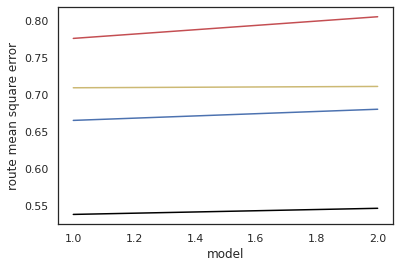

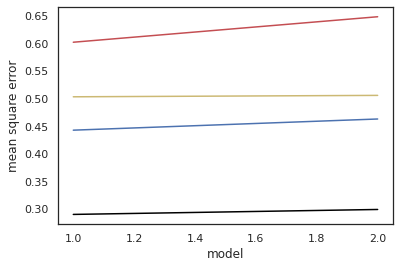

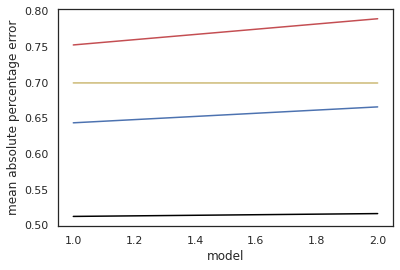

In [22]:
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m1,'b',label='rmse_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m2,'r',label='rmse_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m3,'y',label='rmse_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m5,'black',label='rmse_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('route mean square error')
plt.show()

plt.plot([i+1 for i in range(len(rmse_m1))],mse_m1,'b',label='mse_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m2,'r',label='mse_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m3,'y',label='mse_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m5,'black',label='mse_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('mean square error')
plt.show()


plt.plot([i+1 for i in range(len(rmse_m1))],mape_m1,'b',label='mape_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m2,'r',label='mape_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m3,'y',label='mape_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m5,'black',label='mape_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('mean absolute percentage error')
plt.show()

# **RMSE group bar graph**

In [23]:
a1=rmse_m1[0]
b1=rmse_m2[0]
c1=rmse_m3[0]
d1=rmse_m5[0]

print(a1)
print(b1)
print(c1)
print(d1)

0.6654371122982661
0.7759394812884549
0.7094094090875935
0.5387324825260419


In [24]:
rmse_models_female=[]
rmse_models_female.append(a1)
rmse_models_female.append(b1)
rmse_models_female.append(c1)
rmse_models_female.append(d1)

rmse_models_female

[0.6654371122982661,
 0.7759394812884549,
 0.7094094090875935,
 0.5387324825260419]

In [25]:
a2=rmse_m1[1]
b2=rmse_m2[1]
c2=rmse_m3[1]
d2=rmse_m5[1]

print(a2)
print(b2)
print(c2)
print(d2)


0.680472325073591
0.8051303887149147
0.7112062340685273
0.5469812357775291


In [26]:
rmse_models_male=[]
rmse_models_male.append(a2)
rmse_models_male.append(b2)
rmse_models_male.append(c2)
rmse_models_male.append(d2)

In [27]:
a=rmse_m1
b=rmse_m2
c=rmse_m3
d=rmse_m5

print(a)
print(b)
print(c)
print(d)

[0.6654371122982661, 0.680472325073591]
[0.7759394812884549, 0.8051303887149147]
[0.7094094090875935, 0.7112062340685273]
[0.5387324825260419, 0.5469812357775291]


In [28]:

mape_m2

[0.7524279918498848, 0.7891511388308163]

In [29]:
sum(mape_m5)/len(mape_m5)

0.5140413936793689

# **MSE Group bar chart**

In [30]:
a=mse_m1
b=mse_m2
c=mse_m3
d=mse_m5

print(a)
print(b)
print(c)
print(d)

[0.44280655042385525, 0.46304258519105895]
[0.6020820786221965, 0.6482349428322296]
[0.5032617097020087, 0.5058143073779369]
[0.290232687728672, 0.2991884722927129]


In [31]:
a11=mse_m1[0]
b11=mse_m2[0]
c11=mse_m3[0]
d11=mse_m5[0]

print(a11)
print(b11)
print(c11)
print(d11)

0.44280655042385525
0.6020820786221965
0.5032617097020087
0.290232687728672


In [32]:
mse_models_female=[]
mse_models_female.append(a11)
mse_models_female.append(b11)
mse_models_female.append(c11)
mse_models_female.append(d11)

mse_models_female

[0.44280655042385525,
 0.6020820786221965,
 0.5032617097020087,
 0.290232687728672]

In [33]:
a22=mse_m1[1]
b22=mse_m2[1]
c22=mse_m3[1]
d22=mse_m5[1]

print(a22)
print(b22)
print(c22)
print(d22)

0.46304258519105895
0.6482349428322296
0.5058143073779369
0.2991884722927129


In [34]:
mse_models_male=[]
mse_models_male.append(a22)
mse_models_male.append(b22)
mse_models_male.append(c22)
mse_models_male.append(d22)

mse_models_male

[0.46304258519105895,
 0.6482349428322296,
 0.5058143073779369,
 0.2991884722927129]

# **MAPE group bar chart**

In [35]:
a5=mape_m1
b5=mape_m2
c5=mape_m3
d5=mape_m5

print(a5)
print(b5)
print(c5)
print(d5)

[0.6432631644959804, 0.6655869506210079]
[0.7524279918498848, 0.7891511388308163]
[0.6991955443952003, 0.6990781523629478]
[0.51205854230053, 0.5160242450582075]


In [36]:
a55=mape_m1[0]
b55=mape_m2[0]
c55=mape_m3[0]
d55=mape_m5[0]

print(a55)
print(b55)
print(c55)
print(d55)

0.6432631644959804
0.7524279918498848
0.6991955443952003
0.51205854230053


In [37]:
mape_models_female=[]
mape_models_female.append(a55)
mape_models_female.append(b55)
mape_models_female.append(c55)
mape_models_female.append(d55)

mape_models_female

[0.6432631644959804, 0.7524279918498848, 0.6991955443952003, 0.51205854230053]

In [38]:
a555=mape_m1[1]
b555=mape_m2[1]
c555=mape_m3[1]
d555=mape_m5[1]

print(a555)
print(b555)
print(c555)
print(d555)

0.6655869506210079
0.7891511388308163
0.6990781523629478
0.5160242450582075


In [39]:
mape_models_male=[]
mape_models_male.append(a555)
mape_models_male.append(b555)
mape_models_male.append(c555)
mape_models_male.append(d555)

mape_models_male

[0.6655869506210079,
 0.7891511388308163,
 0.6990781523629478,
 0.5160242450582075]

# **Ploting group bar chart**

   Gender   cf_cosine    cf_svd   cf_euclidean  cf_manhanttan
0  Female    0.667042  0.778308       0.714697       0.545507
1    Male    0.687927  0.814146       0.719969       0.558381


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

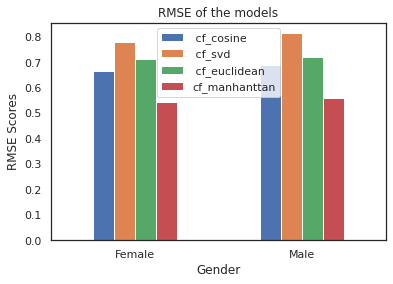

In [40]:


# create data
df = pd.DataFrame([['Female', 0.6670415542640526,
 0.7783076800765676,
 0.7146969413504908,
 0.5455074117238639], ['Male', 0.6879266279852898, 0.814145686581211, 0.7199689191006653, 0.5583809203153479]],
                  columns=['Gender', ' cf_cosine', ' cf_svd', ' cf_euclidean', 'cf_manhanttan'])
# view data
print(df)
  
# plot grouped bar chart
df.plot(x='Gender',
        kind='bar',
        stacked=False,
        title='RMSE of the models')
plt.ylabel("RMSE Scores")

plt.xticks(rotation=360)


   Gender   cf_cosine    cf_svd   cf_euclidean  cf_manhanttan
0  Female    0.444944  0.605763       0.510792       0.297578
1    Male    0.473243  0.662833       0.518355       0.311789


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

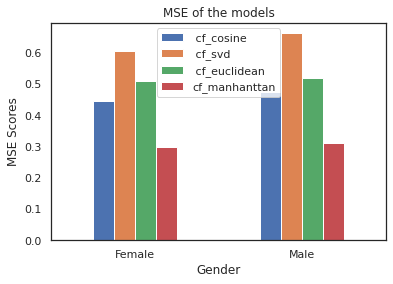

In [41]:
# create data
df = pd.DataFrame([['Female', 0.44494443511500303,
 0.6057628448661686,
 0.5107917179757469,
 0.2975783362456691], ['Male', 0.47324304549121127,
 0.6628331989787914,
 0.5183552444709804,
 0.3117892521722149]],
                  columns=['Gender', ' cf_cosine', ' cf_svd', ' cf_euclidean', 'cf_manhanttan'])
# view data
print(df)
  
# plot grouped bar chart
df.plot(x='Gender',
        kind='bar',
        stacked=False,
        title='MSE of the models')
plt.ylabel("MSE Scores")

plt.xticks(rotation=360)


   Gender   cf_cosine    cf_svd   cf_euclidean  cf_manhanttan
0  Female    0.642596  0.752378       0.705202       0.517590
1    Male    0.670745  0.793648       0.700572       0.517489


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

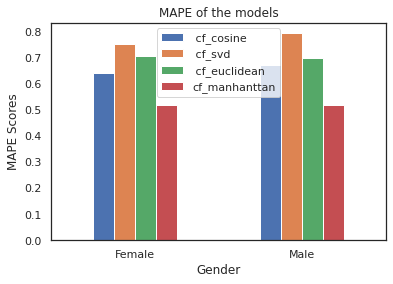

In [42]:
# create data
df = pd.DataFrame([['Female', 0.6425962026739687,
 0.7523784773473424,
 0.7052020264097402,
 0.5175902264179727], ['Male',0.6707450927824425,
 0.7936479501181415,
 0.7005724277138031,
 0.5174885744178287]],
                  columns=['Gender', ' cf_cosine', ' cf_svd', ' cf_euclidean', 'cf_manhanttan'])
# view data
print(df)
  
# plot grouped bar chart
df.plot(x='Gender',
        kind='bar',
        stacked=False,
        title='MAPE of the models')
plt.ylabel("MAPE Scores")

plt.xticks(rotation=360)

# Prediction

In [43]:
def recommend(Gender,course,sim_mat,top_n):
    sim_mat=sim_mat[(Gender)] #get which gender then see which model to use
    idx=np.where(courses==course)[0][0] # get the course and look through
    sim_array=sim_mat[idx] #put the index from the previous line into the sim_mat
    print(sim_array[idx])

    sim_array[idx]=-1000 # minus 1000 to get the idx, forcing that value to large negetive value.
    scores=list(enumerate(sim_array)) #To specify each course of a sequence individually
    sorted_array=np.array(sorted(scores,key=lambda x: x[1], reverse=True),dtype='uint8')[:,0] # sort and print top 5
    print(courses[sorted_array[:top_n]])

# Testing the model with some values

In [44]:
Gender='Female'
course='Business & Financial Technology (SIT)'
recommend(Gender,course,sim_mat_dic_m1,5)
recommend(Gender,course,sim_mat_dic_m2,5)
recommend(Gender,course,sim_mat_dic_m3,5)
recommend(Gender,course,sim_mat_dic_m5,5)

1.000000000000001
['Common Business Programme (SBM)'
 'Business Intelligence & Analytics (SIT)' 'Banking & Finance (SBM)'
 'Business Management (SBM)' 'Information Technology (SIT)']
1.0
['Common Business Programme (SBM)'
 'Business Intelligence & Analytics (SIT)' 'Banking & Finance (SBM)'
 'Accountancy & Finance (SBM)' 'Business Management (SBM)']
1.0
['Common Business Programme (SBM)'
 'Business Intelligence & Analytics (SIT)' 'Banking & Finance (SBM)'
 'Information Technology (SIT)' 'Business Management (SBM)']
1.0
['Common Business Programme (SBM)'
 'Business Intelligence & Analytics (SIT)' 'Banking & Finance (SBM)'
 'Information Technology (SIT)' 'Business Management (SBM)']


In [45]:
Gender='Male'
course='Cybersecurity  & Digital Forensics (SIT)'
recommend(Gender,course,sim_mat_dic_m1,5)
recommend(Gender,course,sim_mat_dic_m2,5)
recommend(Gender,course,sim_mat_dic_m3,5)
recommend(Gender,course,sim_mat_dic_m5,5)

1.000000000000001
['Common ICT Programme (SIT)' 'Information Technology (SIT)'
 'Infocomm & Security (SIT)' 'Game Development & Technology (SDM)'
 'AI & Data Engineering (SEG)']
1.0
['Common ICT Programme (SIT)' 'Information Technology (SIT)'
 'Infocomm & Security (SIT)' 'Game Development & Technology (SDM)'
 'AI & Data Engineering (SEG)']
1.0
['Information Technology (SIT)' 'Common ICT Programme (SIT)'
 'Infocomm & Security (SIT)' 'Game Development & Technology (SDM)'
 'AI & Data Engineering (SEG)']
1.0
['Information Technology (SIT)' 'Common ICT Programme (SIT)'
 'Infocomm & Security (SIT)' 'Game Development & Technology (SDM)'
 'AI & Data Engineering (SEG)']


In [46]:
Gender='Male'
course='Common Business Programme (SBM)'
recommend(Gender,course,sim_mat_dic_m5,5)

1.0
['Banking & Finance (SBM)' 'Business Management (SBM)'
 'Accountancy & Finance (SBM)' 'Sport & Wellness Management (SBM)'
 'Interaction Design (SDM)']


In [47]:
Gender='Female'
course='Experiential Product & Interior Design (SDM)'
recommend(Gender,course,sim_mat_dic_m1,5)
recommend(Gender,course,sim_mat_dic_m2,5)
recommend(Gender,course,sim_mat_dic_m3,5)
recommend(Gender,course,sim_mat_dic_m5,5)

1.0000000000000002
['Interaction Design (SDM)' 'Motion Graphics Design (SDM)'
 'Visual Communication (SDM)' 'Animation & Visual Effects (SDM)'
 'Mass Media Management (SBM)']
1.0000000000000002
['Interaction Design (SDM)' 'Motion Graphics Design (SDM)'
 'Visual Communication (SDM)' 'Animation & Visual Effects (SDM)'
 'Mass Media Management (SBM)']
1.0
['Interaction Design (SDM)' 'Visual Communication (SDM)'
 'Motion Graphics Design (SDM)' 'Animation & Visual Effects (SDM)'
 'Architecture  (SDM)']
1.0
['Interaction Design (SDM)' 'Visual Communication (SDM)'
 'Motion Graphics Design (SDM)' 'Animation & Visual Effects (SDM)'
 'Architecture  (SDM)']


In [48]:
Gender='Female'
course='Applied Chemistry (SAS)'
recommend(Gender,course,sim_mat_dic_m1,5)
recommend(Gender,course,sim_mat_dic_m2,5)
recommend(Gender,course,sim_mat_dic_m3,5)
recommend(Gender,course,sim_mat_dic_m5,5)

1.0000000000000007
['Pharmaceutical Science (SAS)'
 'Chemical & Pharmaceutical Technology (SAS)'
 'Food Science & Nutrition (SAS)' 'Biologics & Process Technology (SAS)'
 'Nursing (SHSS)']
1.0
['Pharmaceutical Science (SAS)'
 'Chemical & Pharmaceutical Technology (SAS)'
 'Food Science & Nutrition (SAS)' 'Biologics & Process Technology (SAS)'
 'Nursing (SHSS)']
1.0
['Pharmaceutical Science (SAS)'
 'Chemical & Pharmaceutical Technology (SAS)'
 'Food Science & Nutrition (SAS)' 'Biologics & Process Technology (SAS)'
 'Nursing (SHSS)']
1.0
['Pharmaceutical Science (SAS)'
 'Chemical & Pharmaceutical Technology (SAS)'
 'Food Science & Nutrition (SAS)' 'Biologics & Process Technology (SAS)'
 'Nursing (SHSS)']
